In [25]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import speclite.filters
from lenstronomy.Util import data_util

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.hwo import HWO
from mejiro.instruments.roman import Roman

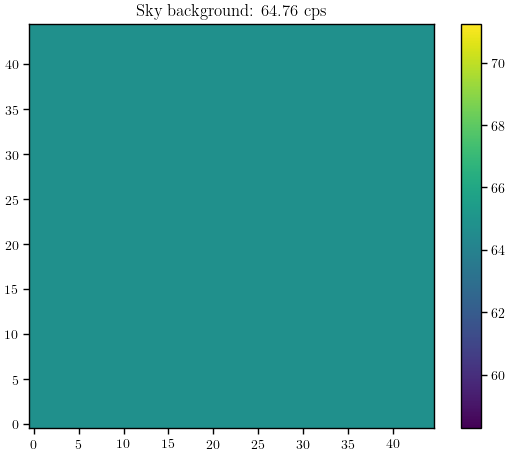

In [26]:
roman = Roman()

bkgs = roman.get_sky_bkgs(['F129'], 146, 45, 1)
bkg = bkgs['F129']
bkg_array = bkg.array
sky_bkg_cps = np.mean(bkg_array)

plt.imshow(bkg_array)
plt.title(f'Sky background: {sky_bkg_cps:.2f} cps')
plt.colorbar()
plt.show()

In [27]:
def get_zeropoint_magnitude(wavelength, response, effective_area=4.5 * 1e4):
    '''
    see Section 6.1 of [this paper](https://www.aanda.org/articles/aa/full_html/2022/06/aa42897-21/aa42897-21.html) by the Euclid collaboration for explanation of this function

    Roman's collecting area (4.5 m^2) retrieved 16 August 2024 from https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/introduction-to-wfi/wfi-quick-reference
    '''
    # effective area in cm^2

    # assert that wavelength values are evenly spaced
    assert np.allclose(np.diff(wavelength), np.diff(wavelength)[0])

    dv = np.diff(wavelength)[0]
    integral = 0
    for wl, resp in zip(wavelength, response):
        integral += (dv * (1 / wl) * resp)

    return 8.9 + (2.5 * np.log10(((effective_area * 1e-23) / (6.602 * 1e-27)) * integral))

calculate zeropoints from original Roman technical specifications filter response curves

In [28]:
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names

configure_roman_filters()
roman_filters = filter_names()
roman_filters.sort()
og_roman_filters = [speclite.filters.load_filter(f) for f in roman_filters[:8]]

original_zeropoints = {}
for filter in og_roman_filters:
    original_zeropoints[filter.name[-4:]] = get_zeropoint_magnitude(filter.wavelength, filter.response)
pprint(original_zeropoints)

{'F062': 26.732004045011998,
 'F087': 26.39959321426133,
 'F106': 26.45879071316798,
 'F129': 26.474852624324505,
 'F146': 27.705289628769542,
 'F158': 26.509375840491877,
 'F184': 26.057270612934154,
 'F213': 26.014557989787512}


zodiacal light and thermal background values from [Roman Technical Documentation](https://roman.gsfc.nasa.gov/science/WFI_technical.html)

In [29]:
pprint(roman.min_zodi)

{'F062': 0.25,
 'F087': 0.251,
 'F106': 0.277,
 'F129': 0.267,
 'F146': 0.781,
 'F158': 0.244,
 'F184': 0.141,
 'F213': 0.118}


In [30]:
pprint(roman.thermal_backgrounds)

{'F062': 0.003,
 'F087': 0.003,
 'F106': 0.003,
 'F129': 0.003,
 'F146': 1.03,
 'F158': 0.048,
 'F184': 0.155,
 'F213': 4.38}


In [31]:
sky_bkg = {key: v1 + v2 for key, v1, v2 in
           zip(roman.thermal_backgrounds.keys(), roman.thermal_backgrounds.values(), roman.min_zodi.values())}

pprint(sky_bkg)

{'F062': 0.253,
 'F087': 0.254,
 'F106': 0.28,
 'F129': 0.27,
 'F146': 1.811,
 'F158': 0.292,
 'F184': 0.296,
 'F213': 4.498}


convert sky backgrounds to magnitudes using original Roman technical specifications filter response curves

In [32]:
sky_bkg_mags = {key: data_util.cps2magnitude(v, original_zeropoints[key]) for key, v in sky_bkg.items()}
pprint(sky_bkg_mags)

{'F062': 28.224202742072453,
 'F087': 27.887508922711486,
 'F106': 27.84089563481243,
 'F129': 27.896443213927036,
 'F146': 27.060493502984396,
 'F158': 27.84591871187083,
 'F184': 27.379041335286807,
 'F213': 24.382009362038477}


sanity check: convert back to counts

In [33]:
sky_bkg_counts_check = {key: data_util.magnitude2cps(v, original_zeropoints[key]) for key, v in sky_bkg_mags.items()}
pprint(sky_bkg_counts_check)

{'F062': 0.2529999999999999,
 'F087': 0.2539999999999996,
 'F106': 0.28000000000000014,
 'F129': 0.2700000000000003,
 'F146': 1.8109999999999988,
 'F158': 0.2920000000000004,
 'F184': 0.2960000000000001,
 'F213': 4.4980000000000055}


convert sky backgrounds to counts for all SCAs

In [34]:
roman_zps = roman.zp_dict
pprint(roman_zps)

{'SCA01': {'F062': 26.573720976925344,
           'F087': 26.22444439663539,
           'F106': 26.31341612265568,
           'F129': 26.31760383446462,
           'F146': 27.53675269415519,
           'F158': 26.320712182222806,
           'F184': 25.852803745658825,
           'F213': 25.81314064968742},
 'SCA02': {'F062': 26.60507741847109,
           'F087': 26.296320101527776,
           'F106': 26.34987398221049,
           'F129': 26.336812298907752,
           'F146': 27.575796666083114,
           'F158': 26.367562639862697,
           'F184': 25.91108650516852,
           'F213': 25.85540398669619},
 'SCA03': {'F062': 26.599516508566303,
           'F087': 26.28133844245408,
           'F106': 26.334876598542735,
           'F129': 26.332589280599407,
           'F146': 27.564432481786795,
           'F158': 26.35750871774671,
           'F184': 25.908985300671034,
           'F213': 25.852467634033083},
 'SCA04': {'F062': 26.5394986263943,
           'F087': 26.2684915430813

In [35]:
sky_bkg_cps_dict = {}

for sca, zp_dict in roman_zps.items():
    sky_bkg_cps_dict[sca] = {}
    for filter, zp in zp_dict.items():
        sky_bkg_cps_dict[sca][filter] = data_util.magnitude2cps(sky_bkg_mags[filter], zp)

pprint(sky_bkg_cps_dict)

{'SCA01': {'F062': 0.21867910811125002,
           'F087': 0.21615943154279874,
           'F106': 0.24491094561065574,
           'F129': 0.23359537950198622,
           'F146': 1.550613913276466,
           'F158': 0.2454242023311866,
           'F184': 0.24519124799285574,
           'F213': 3.7363927013479326},
 'SCA02': {'F062': 0.22508671893896293,
           'F087': 0.23095345923818741,
           'F106': 0.25327442552162943,
           'F129': 0.23776484066558223,
           'F146': 1.6073900114754978,
           'F158': 0.2562462810995016,
           'F184': 0.258712890354565,
           'F213': 3.884703258382817},
 'SCA03': {'F062': 0.22393681992331366,
           'F087': 0.22778850689378216,
           'F106': 0.24979997207703686,
           'F129': 0.23684184013989606,
           'F146': 1.5906535223743214,
           'F158': 0.25388439181936173,
           'F184': 0.2582126924171551,
           'F213': 3.8742113471899975},
 'SCA04': {'F062': 0.21189385087018095,
          